In [1]:
import pandas as pd
import numpy as np
from scipy import stats # For in-built method to get PCC
import scipy
from sklearn.model_selection import KFold
import pingouin as pg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from zca import zca
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.tools
import matplotlib.pyplot as plt
zca = zca.ZCA()

In [2]:
target = 'Poverty'

all_data = pd.read_csv('../data/raw/states.csv')

scaler.fit(np.array(all_data[target]).reshape(-1, 1))

StandardScaler()

In [3]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(all_data.index)

10

In [4]:
def fit_linear_reg(X,Y,train_i,test_i):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X.iloc[train_i],Y.iloc[train_i])
    RSS = mean_squared_error(Y.iloc[test_i],model_k.predict(X.iloc[test_i])) * len(Y)
    R_squared = model_k.score(X.iloc[test_i],Y.iloc[test_i])
    return RSS, R_squared

In [5]:
exclude = 'States'

sig_table = np.zeros(shape=(len(all_data.columns)))
signs_table = np.zeros(shape=(len(all_data.columns)))

p_threshold = .05

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=num_folds)
train_ = []
test_ = []
for train_indices, test_indices in k_fold.split(all_data.index):
    train_.append(train_indices)
    test_.append(test_indices)

for it in range(0,len(train_)):
    max_pvalue = 1
    train_index = train_[it]
    test_index = test_[it]
    #display(all_data.iloc[test_index].describe())
    
    subset = all_data.iloc[train_index].loc[:, ~all_data.columns.isin([exclude])]
    
    #skip y and states
    set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    n=len(subset)
    
    while(max_pvalue>=.05):

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target]))).T
        p_values.columns = list(subset.columns)
        
        max_pname = p_values.idxmax(axis=1)[0]
        max_pvalue = p_values[max_pname].values[0]
        
        if (max_pvalue > .05):

            set_.remove(max_pname)
            temp = [target]
            temp.extend(set_)
            subset = subset[temp]
    
    winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
    sig_table = (sig_table + np.where(all_data.columns.isin(winners),1,0)).copy()
    signs_table[all_data.columns.get_indexer(winners)]+=np.where(subset.pcorr()[target][winners]<0,-1,1)

In [6]:
significance = pd.DataFrame(sig_table).T
significance.columns = list(all_data.columns)
display(significance)

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,1.0,10.0,0.0,0.0,1.0,0.0,10.0,10.0,7.0


In [7]:
sign = pd.DataFrame(signs_table).T
sign.columns = list(all_data.columns)
display(sign)


,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,-1.0,-10.0,0.0,0.0,-1.0,0.0,10.0,-10.0,7.0


In [8]:
purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
display(purity.T)

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,0.1,1.0,0.0,0.0,0.1,0.0,1.0,1.0,0.7


In [9]:
threshold = 0

chosen = list(purity.T.columns.values[np.array(purity.T>threshold).reshape(len(all_data.columns,))])
dataSet = pd.concat([all_data[target],all_data[chosen]],axis=1)
y_scaled = pd.DataFrame(scaler.transform(np.array(dataSet[target]).reshape(-1, 1)))
y_scaled.columns=[target]


In [10]:
display(chosen)

['Infant Mort', 'White', 'Traf Deaths', 'Unemployed', 'Income', 'Population']

In [11]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#Initialization variables
Y = all_data[target]
#X = all_data.iloc[:,2:]
X = all_data[chosen]
k = 10
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        #display(all_data.iloc[test_index].describe())
        tmp_result = []
        for it in range(0,len(train_)):
            tmp_result.append(fit_linear_reg(X[list(combo)],Y,train_[it],test_[it]))   #Store temp result )
        
        RSS_list.append(np.average(tmp_result,axis=0)[0])                  #Append lists
        R_squared_list.append(np.average(tmp_result,axis=0)[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

C:\Users\User\AppData\Local\Temp/ipykernel_22172/500784623.py:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

In [13]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]


In [14]:
df_min

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
4,1,136.404405,0.533514,"(Income,)",136.404405,0.533514
18,2,104.298897,0.601244,"(Unemployed, Income)",104.298897,0.601244
34,3,80.230651,0.624001,"(White, Unemployed, Income)",80.230651,0.629563
54,4,72.401282,0.670223,"(White, Unemployed, Income, Population)",72.401282,0.670223
61,5,69.694921,0.682539,"(White, Traf Deaths, Unemployed, Income, Popul...",69.694921,0.682539
62,6,92.061734,0.475684,"(Infant Mort, White, Traf Deaths, Unemployed, ...",92.061734,0.475684


In [15]:
CV_parse = list(df_min[(df_min['RSS']<=(np.min(df_min['RSS'])+np.std(df_min['RSS'])))].sort_values(kind="quicksort", ascending=True, by='RSS',key=abs).iloc[0]['features'])

In [16]:
display(CV_parse)

['White', 'Traf Deaths', 'Unemployed', 'Income', 'Population']

In [17]:
zca_data = pd.concat([y_scaled,pd.DataFrame(zca.fit_transform(dataSet[CV_parse]),columns=CV_parse)],axis=1)

In [18]:
zca_data.pcorr()

,Poverty,White,Traf Deaths,Unemployed,Income,Population
Poverty,1.000000,-0.611186,0.207474,0.390783,-0.921306,0.365956
White,-0.611186,1.000000,0.126803,0.238841,-0.563089,0.223667
Traf Deaths,0.207474,0.126803,1.000000,-0.081081,0.191147,-0.075926
Unemployed,0.390783,0.238841,-0.081081,1.000000,0.360031,-0.143009
Income,-0.921306,-0.563089,0.191147,0.360031,1.000000,0.337157
Population,0.365956,0.223667,-0.075926,-0.143009,0.337157,1.000000


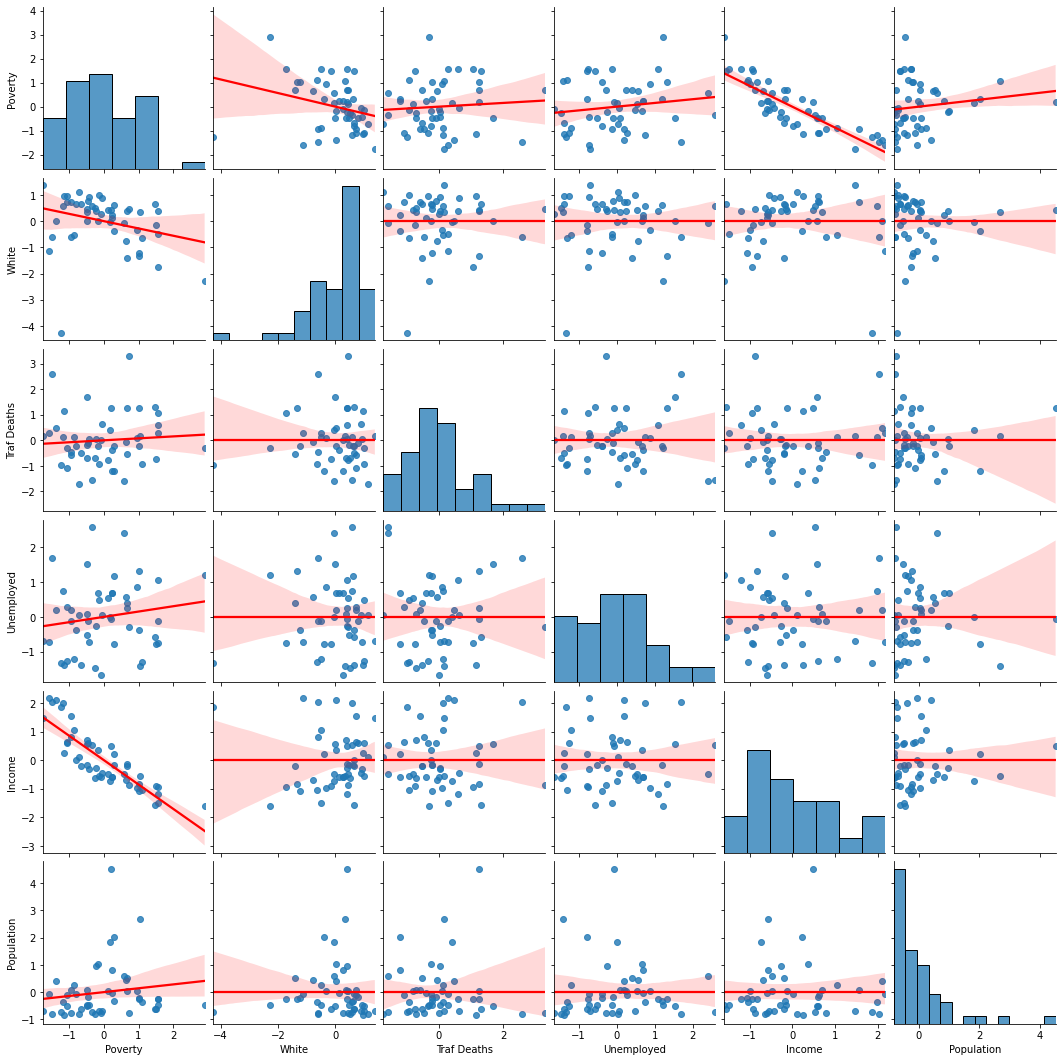

In [19]:
sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [20]:

#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
y = data_set_wConstant[target]
X = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y,X)
results = model.fit()
fitted = results.predict(X)

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     57.99
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           2.97e-18
Time:                        08:00:48   Log-Likelihood:                -20.276
No. Observations:                  50   AIC:                             52.55
Df Residuals:                      44   BIC:                             64.02
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.743e-16      0.055    1.6e-14      1.000      -0.110       0.110
White          -0.2831      0.055     -5.122      0.000      -0.395      -0.172
Traf Deaths     0.0778      0.055      1.407      0.167      -0.034       0.189
Unemployed      0.1557      0.055      2.816      0.007       0.044       0.267
Income         -0.8688      0.055    -15.717      0.000      -0.980      -0.757
Population      0.1442      0.055      2.608      0.012       0.033       0.256
==============================================================================
Omnibus:                        2.493   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.333
Skew:                           0.509   Prob(JB):                        0.311
Kurtosis:                       2.714   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

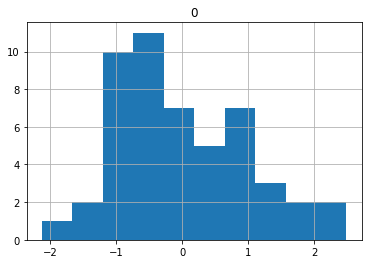

In [22]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

In [23]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\users

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     57.99
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           2.97e-18
Time:                        08:00:48   Log-Likelihood:                -20.276
No. Observations:                  50   AIC:                             52.55
Df Residuals:                      44   BIC:                             64.02
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e-16      0.

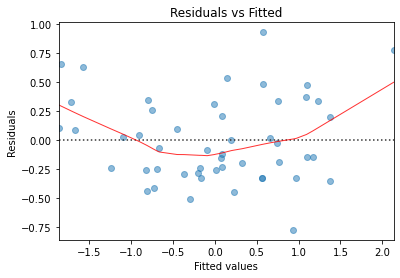

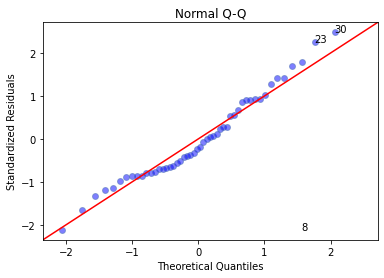

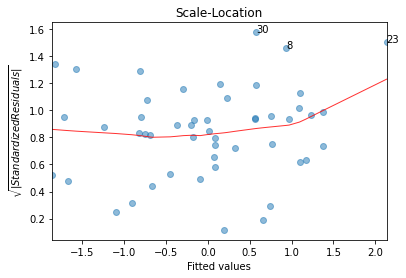

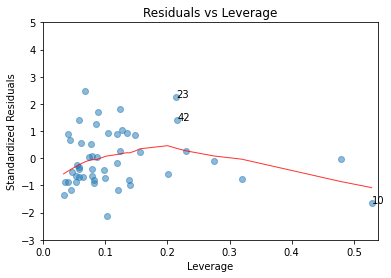

In [24]:
linear_plot = Plot.LinearRegressionResidualPlot(X.values, y.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


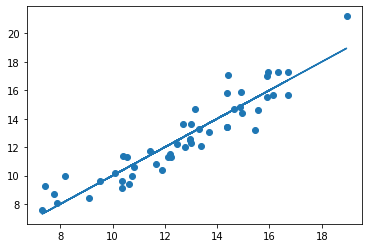

In [25]:
plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0])

m, b = np.polyfit(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], m*results.fittedvalues*scaler.scale_[0] + scaler.mean_[0] + b)

In [26]:
print(m)
print(b)

0.9999999999999992
6.0291550413456946e-15


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from numpy import *
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
#ENresults = search.fit(X[.loc[:, ~X.columns.isin(['const'])], y)
#ENfitted = ENresults.predict(X.loc[:, ~X.columns.isin(['const'])])
ENresults = search.fit(all_data[CV_parse], y)
ENfitted = ENresults.predict(all_data[CV_parse])

# summarize
print('MAE: %.3f' % ENresults.best_score_)
print('Config: %s' % ENresults.best_params_)

MAE: -0.339
Config: {'alpha': 0.0, 'l1_ratio': 0.0}


c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\sklearn\model_selection\_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2937681778443753, tolerance: 0.004999999999999998
  model = cd_fast.enet_coordinate_descent(


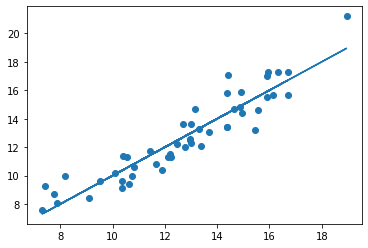

In [28]:
#ENfitted = ENresults.predict(X.loc[:, ~X.columns.isin(['const'])])
ENfitted = ENresults.predict(all_data[CV_parse])
plt.scatter(ENfitted*scaler.scale_[0] + scaler.mean_[0],y*scaler.scale_[0] + scaler.mean_[0])
m, b = np.polyfit(ENfitted*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(ENfitted*scaler.scale_[0] + scaler.mean_[0], m*ENfitted*scaler.scale_[0] + scaler.mean_[0] + b)

In [29]:

# ransac regression on a dataset with outliers
import pandas as pd
from random import random
from random import randint
from random import seed
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()




Mean MAE: 0.383 (0.129)


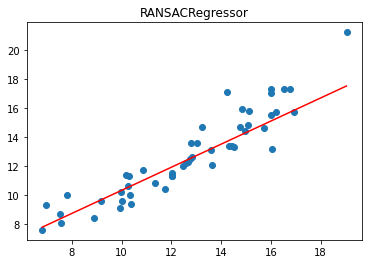

In [32]:
# define the model
model = RANSACRegressor()
# evaluate model
#Rresults = evaluate_model(X.loc[:, ~X.columns.isin(['const'])], y, model)
Rresults = evaluate_model(all_data[CV_parse], y, model)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults), std(Rresults)))
# plot the line of best fit
Rresults = model.fit(all_data[CV_parse],y)
RFitted = Rresults.predict(all_data[CV_parse])
plot_best_fit(RFitted.reshape(-1, 1)*scaler.scale_[0] + scaler.mean_[0],y*scaler.scale_[0] + scaler.mean_[0], model)

In [33]:
print("OLS: " + str(mean_squared_error(y,fitted) * len(y)))
print("EN: " + str(mean_squared_error(y,ENfitted) * len(y)))
print("Robust: " + str(mean_squared_error(y,RFitted) * len(y)))

OLS: 6.587536355688749
EN: 6.58753635568875
Robust: 7.24936814356626
